In [128]:

import pandas as pd
import pymysql
from sql_info import USER, PASSWORD, DB_NAME
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc 
import seaborn as sns 

# 한글 깨지는 현상 수정
f_path = "C:/windows/Fonts/malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')


import warnings
warnings.filterwarnings(action = 'ignore')

pd.set_option('display.max_colwidth', 100) # 데이터의 길이가 길면 ...되는 부분을 없앰


In [78]:
# 22년 1월 1일부터 데이터가 수집되었음 - 조회시 참고
def read_sql_weeks(weeks = 4, read_all = False):

    db = pymysql.connect(host='localhost', user = USER, passwd = PASSWORD, db = DB_NAME, charset = 'utf8')

    # 일단 메모리 측면에서 생각해보면 당연히 쿼리를 날려서 일부 데이터만 메모리에 올리는 쪽이 훨씬 효율적일 것

    end_date = datetime.today().date()
    
    if read_all:
        start_date = '2022-01-01'
    else:
        start_date = end_date - timedelta(weeks = weeks)
    
    query1 = f"SELECT * FROM reports WHERE date >= '{start_date}' and date <= '{end_date}'"

#     query1 = (f"SELECT r.company as company, r.date as date, r.written_by as written_by, \
#             c.code as company_code, c.category as category, r.reports_idx as reports_idx\
#             FROM reports r \
#             JOIN companies c \
#             ON r.company = c.company \
#             WHERE date >= '{start_date}' and date <= '{end_date}'")

    query2 = (f"SELECT * \
                FROM companies")

    reports_df = pd.read_sql_query(query1, db)
    companies_df = pd.read_sql_query(query2, db)
    # reports_df.drop_index()

    db.close()

    return reports_df, companies_df, start_date, end_date


# 가공하는 부분을 따로 떼어냄
def processing_df(reports_df, companies_df):
    
    # reports_df 항목 수정 : 
    HK_URL =  "http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx="
    reports_df['reports_link'] = HK_URL + reports_df['reports_idx']

    # date는 object로 불러오므로 날짜 데이터로 변환
    reports_df['date'] = pd.to_datetime(reports_df['date'])
    
    # 필요없는 column들 제거
    reports_df.drop(['id', 'reports_idx'], axis = 1, inplace = True)
    
    # 인덱스 초기화
    reports_df.reset_index()
    


    # companies_df 항목 수정 : 기업 코드 제거 & 해당 종목 네이버증권 URL 첨부
    NAVER_COMPANY_INFO_URL = "https://finance.naver.com/item/main.naver?code="
    companies_df['companies_info'] = NAVER_COMPANY_INFO_URL + companies_df['code']
    companies_df.drop('code', axis = 1, inplace = True)
    
    # 리턴이 굳이 필요 없지 않나? - 어차피 어떤 주소값에 있는 df를 바꾸는 내용임
    # return reports_df, companies_df

# 필요하다면 merge를 해준다
def merge_df(reports_df, companies_df):
    total_df = pd.merge(reports_df, companies_df, on = 'company')
    return total_df
    

In [79]:
reports_df, companies_df, start_date, end_date = read_sql_weeks(read_all = True)
processing_df(reports_df, companies_df)

total_df = merge_df(reports_df, companies_df)
total_df.head(10)

,company,date,written_by,reports_link,category,companies_info
0,카카오,2022-08-08,대신증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612453,양방향미디어와서비스,https://finance.naver.com/item/main.naver?code=035720
1,카카오,2022-08-05,이베스트증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612334,양방향미디어와서비스,https://finance.naver.com/item/main.naver?code=035720
2,셀트리온,2022-08-08,한화투자증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612443,제약,https://finance.naver.com/item/main.naver?code=068270
3,셀트리온,2022-07-18,한화투자증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=611529,제약,https://finance.naver.com/item/main.naver?code=068270
4,롯데쇼핑,2022-08-08,이베스트증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612393,백화점과일반상점,https://finance.naver.com/item/main.naver?code=023530
5,카카오게임즈,2022-08-04,이베스트증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612292,게임엔터테인먼트,https://finance.naver.com/item/main.naver?code=293490
6,카카오게임즈,2022-03-23,이베스트증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=606748,게임엔터테인먼트,https://finance.naver.com/item/main.naver?code=293490
7,제이브이엠,2022-08-03,한화투자증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612266,건강관리장비와용품,https://finance.naver.com/item/main.naver?code=054950
8,제이브이엠,2022-07-29,이베스트증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=612016,건강관리장비와용품,https://finance.naver.com/item/main.naver?code=054950
9,제이브이엠,2022-07-11,IBK투자증권,http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx=611220,건강관리장비와용품,https://finance.naver.com/item/main.naver?code=054950


In [87]:
category_lst = total_df['category'].value_counts()
print(category_lst)

전자장비와기기         40
은행              32
반도체와반도체장비       28
화장품             17
화학              17
전기제품            16
방송과엔터테인먼트       16
제약              13
게임엔터테인먼트        12
손해보험            12
건강관리장비와용품       11
우주항공과국방         10
섬유,의류,신발,호화품    10
백화점과일반상점        10
음료               9
광고               9
자동차부품            9
비철금속             9
식품               8
건설               8
다각화된통신서비스        8
자동차              7
핸드셋              7
철강               7
식품과기본식료품소매       5
항공사              5
기계               5
항공화물운송과물류        4
해운사              4
무선통신서비스          4
디스플레이장비및부품       4
석유와가스            4
소프트웨어            3
복합기업             3
조선               3
도로와철도운송          2
IT서비스            2
양방향미디어와서비스       2
생명보험             2
증권               2
전기장비             2
전자제품             2
디스플레이패널          2
카드               1
전문소매             1
호텔,레스토랑,레저       1
전기유틸리티           1
담배               1
Name: category, dtype: int64


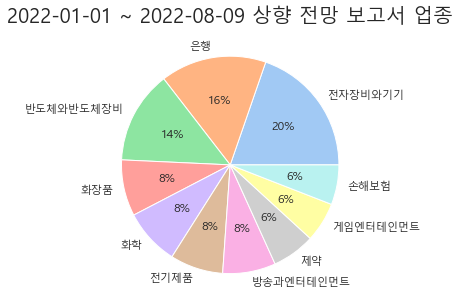

In [150]:
# 시각화
# 1. 가장 많은 상향 보고서가 나온 산업 순서 - 파이 차트를 이용해보자

colors = sns.color_palette('pastel')[0:10]

plt.figure(figsize = (10, 5), facecolor = 'white')
plt.pie(category_lst.values[0:10], 
        labels = category_lst.index[0:10],
        colors = colors,
        autopct = "%.0f%%") # 부채꼴 안에 표시되는 숫자의 형식
plt.title(f'{start_date} ~ {end_date} 상향 전망 보고서 업종', fontdict = {'fontsize' : 20})
plt.show()


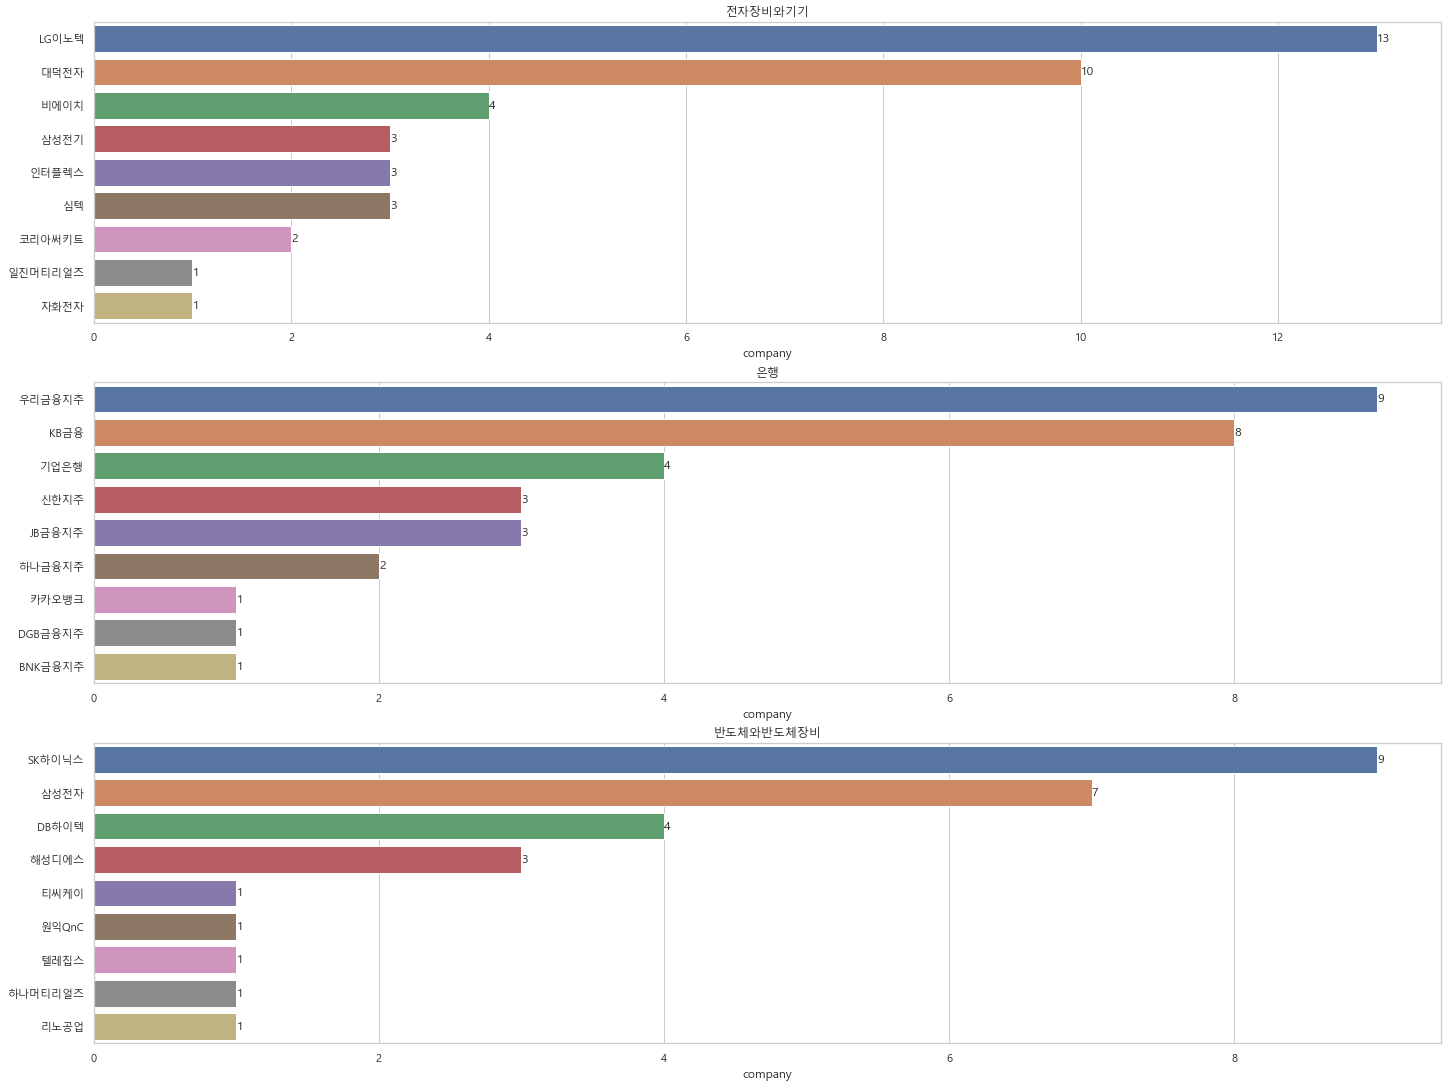

In [156]:
# 2. 디테일 : 상위 3개 분야의 상향 보고서가 나온 기업들 조회
# cp_lst = total_df[total_df['category'] == "전자장비와기기"]['company'].value_counts()

# 상위 3개의 분야에 대해 나온 기업들 리스트를 쫙 조회할 거임

fig, axes = plt.subplots(3, 1, figsize = (20, 15), 
                         constrained_layout = True) # subplots 간 간격 최적화

for i in range(3):
    cp_lst = total_df[total_df['category'] == category_lst.index[i]]['company'].value_counts()
    axes[i].title.set_text(category_lst.index[i])
    # axes[i][0] = sns.barplot(x = cp_lst, y = cp_lst.index)
    sns.barplot(x = cp_lst, y = cp_lst.index, ax = axes[i])
    axes[i].bar_label(axes[i].containers[0])

# sns.despine(bottom = True)

In [252]:
# 220810부터 계속~
# groupby를 쓸 수 있지 않을까?
# 연-월 데이터만 이용해보자
total_df['YearMonth'] = total_df['date'].dt.strftime('%Y-%m')

heatmap_df = total_df[['company', 'YearMonth', 'category']]
heatmap_df = heatmap_df.groupby(['company', 'YearMonth']).size()

heatmap_df = heatmap_df.to_frame()
heatmap_df.head()
# for column in heatmap_df.columns:
#     print(column)
# heatmap_df.pivot('company')

0
company YearMonth   
BGF리테일  2022-04    1
        2022-05    4
BNK금융지주 2022-02    1
CJ ENM  2022-02    1
CJ제일제당  2022-02    1

company  YearMonth
BGF리테일   2022-04      1
         2022-05      4
BNK금융지주  2022-02      1
CJ ENM   2022-02      1
CJ제일제당   2022-02      1
                     ..
현대해상     2022-04      1
         2022-05      1
         2022-06      1
효성화학     2022-01      1
후성       2022-02      1
Length: 281, dtype: int64

TypeError: heatmap() missing 1 required positional argument: 'data'

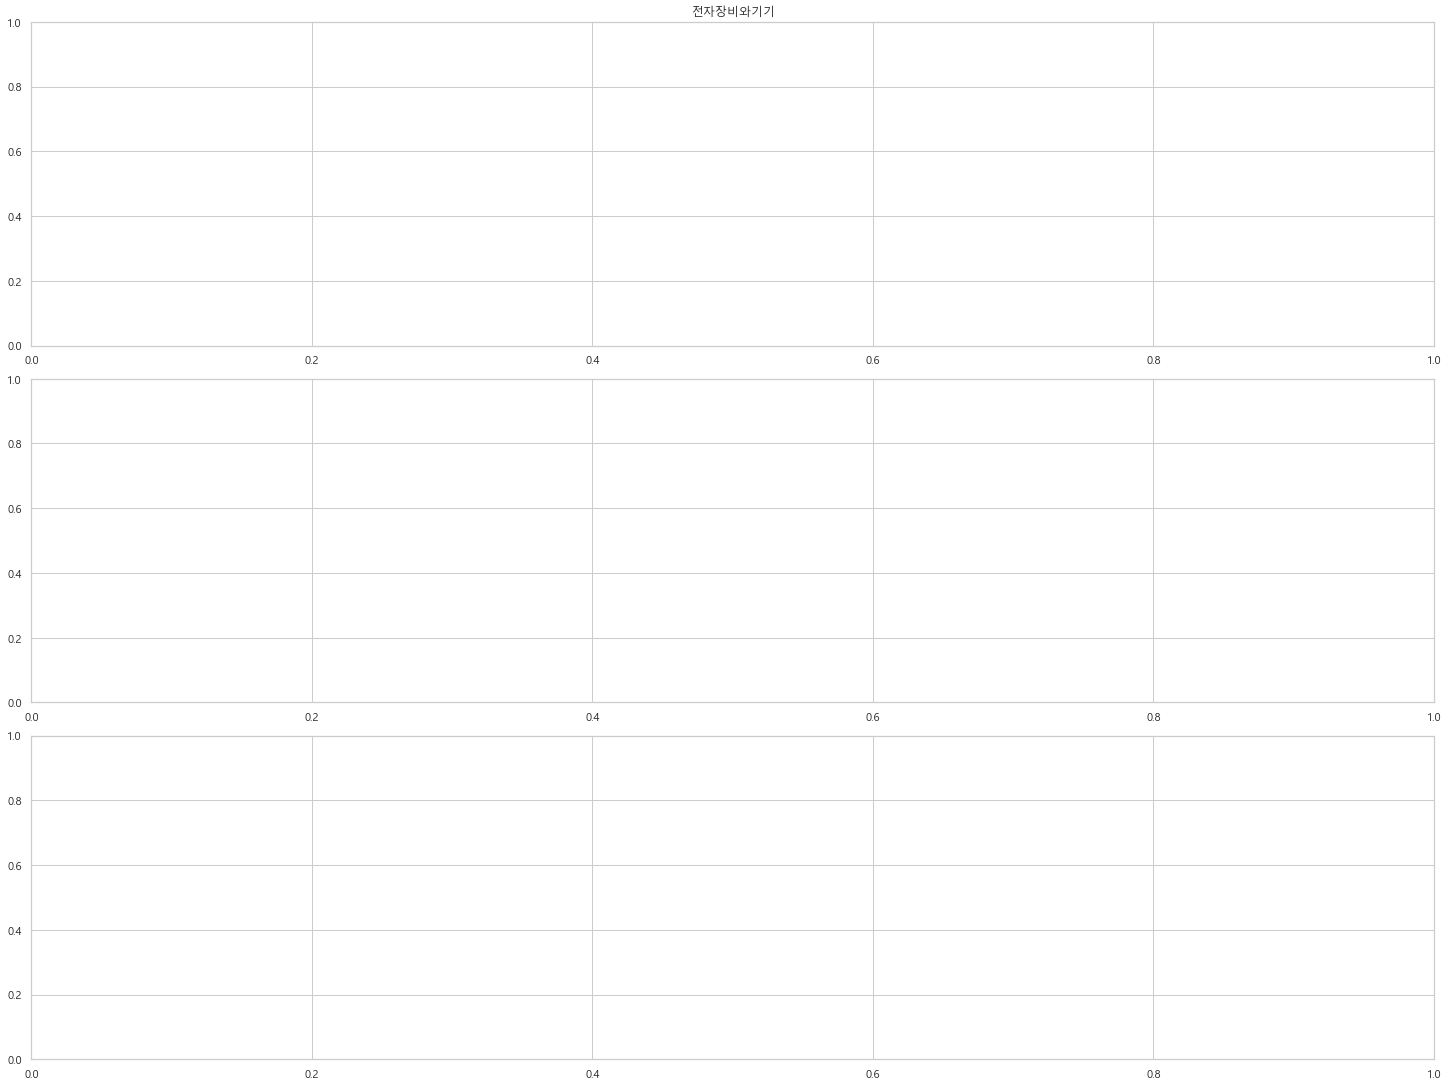

In [162]:
# 3. 위 막대그래프를 히트맵으로 바꾸고, 보고서가 나온 날짜
fig, axes = plt.subplots(3, 1, figsize = (20, 15), 
                         constrained_layout = True)

for i in range(3):
    cp_lst = total_df[total_df['category'] == category_lst.index[i]][['company', 'date']].value_counts()
    axes[i].title.set_text(category_lst.index[i])
    # axes[i][0] = sns.barplot(x = cp_lst, y = cp_lst.index)
    sns.heatmap(x = cp_lst, y = cp_lst.index, ax = axes[i])
    axes[i].bar_label(axes[i].containers[0])